# Willman 1: Member sample

Import necessary packages

In [ ]:
import pandas as pd
pd.set_option('display.max_columns', None) # display whole table in line
pd.set_option('display.max_rows', None)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.patches import Polygon
import seaborn as sns

import astropy
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table

import membership_utils
import properties_utils
import wil1_properties
from wil1_properties import aax, bax, r_half, alpha, ecc, dist, ra_w1, dec_w1

In [11]:
# some code for prettier plots
%config InlineBackend.figure_format = 'retina'
plt.rcParams.update({'axes.linewidth' : 1,
                     'ytick.major.width' : 1,
                     'ytick.minor.width' : 1,
                     'xtick.major.width' : 1,
                     'xtick.minor.width' : 1,
                     'xtick.labelsize': 12, 
                     'ytick.labelsize': 12,
                     'axes.labelsize': 16,
                     'font.family': 'Serif',
                     'figure.figsize': (10, 6),
                     'xtick.direction': 'in',
                     'ytick.direction': 'in',
                     'xtick.major.size': 8,
                     'ytick.major.size': 8,
                     'xtick.minor.size': 4,
                     'ytick.minor.size': 4})

## Open data & data overview

In [12]:
# open deimos data evaluated for membership
full_deimos = pd.read_csv("data/dmost_alldata_evaluated.csv", index_col = 0)

In [13]:
member_mask    = (full_deimos["prob_member"] >= 0.5)
sixrhalf_mask  = (full_deimos["hl_radius_ell"] <= 6)
onerhalf_mask  = (full_deimos["hl_radius_ell"] <= 1)
gaia_mask      = (full_deimos["gaia_pmra_err"] > 0) & (full_deimos["pm_err_flag"] == 0)
mult_mask      = (full_deimos["flag_var"] != -99) # (full_deimos["nmask"] > 1)
variable       = (full_deimos["flag_var"] == 1)

member_tot          = full_deimos[member_mask]
w1_members          = full_deimos[member_mask & sixrhalf_mask & ~variable]
gaia_members        = full_deimos[member_mask & gaia_mask & ~variable]
rhalf_members       = full_deimos[member_mask & onerhalf_mask & ~variable] # mult_mask
mems_meas, mems_var = full_deimos[member_mask & mult_mask], full_deimos[member_mask & variable]

print("Members + gaia:                        {}".format(len(full_deimos[member_mask & gaia_mask])))
print("Members, <1rhalf:                      {}".format(len(full_deimos[member_mask & onerhalf_mask])))
print("Members, <1rhalf, mult epochs, no var: {}".format(len(full_deimos[member_mask & onerhalf_mask & mult_mask & ~variable])))
print("Members, mult epochs:                  {}".format(len(mems_meas)))
print("Member (<6 rhalf, no var):             {}".format(len(w1_members)))
print("Members total:                         {}".format(len(member_tot)))
print("{} variable(s) out {} measured.\n".format(len(mems_var), len(mems_meas)))

Members + gaia:                        7
Members, <1rhalf:                      28
Members, <1rhalf, mult epochs, no var: 25
Members, mult epochs:                  57
Member (<6 rhalf, no var):             50
Members total:                         57
6 variable(s) out 57 measured.



## Comparison to literature samples

In [14]:
# open Willman 2011 sample data
published_sample = pd.read_csv("data/2011_published_sample.csv")
published_mwfgs = pd.read_csv("data/2011_mwforeground_sample.csv")

Comparison with published 2011 sample:

In [15]:
# astropy coordinates of published, deimos data
c_published = SkyCoord(published_sample["ra"], published_sample["dec"], unit = u.degree)
c_deimos = SkyCoord(full_deimos["RA"], full_deimos["DEC"], unit = u.degree)

# matching criteria within 1 arcsec
index, d2d, d3d = c_published.match_to_catalog_sky(c_deimos)
foo = np.arange(0, np.size(index), 1)
match_published  = foo[d2d < 1.5 * u.arcsec]
match_deimos = index[d2d < 1.5 * u.arcsec]

# new df with matched deimos/gaia data
published_data_match = published_sample.iloc[match_published]
deimos_data_match = full_deimos.iloc[match_deimos]
deimos_published_combined = pd.concat([published_data_match, deimos_data_match.set_axis(published_data_match.index)], axis = 1)

print(f"{len(deimos_published_combined)} matches out of {len(published_sample)} 2011 members.")

45 matches out of 45 2011 members.


In [16]:
member_2011 = deimos_published_combined[deimos_published_combined["sample"] == 1]
nonmember_2011 = deimos_published_combined[(deimos_published_combined["sample"] == 0) | np.isnan(deimos_published_combined["sample"])]

print(f"2011 members in exclusive sample: {len(member_2011)}")
print(f"Variable stars in 2011 member sample: {np.sum(deimos_published_combined["flag_var"] == 1)}")
print(f"2011 members labeled non-members: {len(nonmember_2011)}")

2011 members in exclusive sample: 31
Variable stars in 2011 member sample: 4
2011 members labeled non-members: 14


In [32]:
nonmember_2011

,Unnamed: 0,ra,dec,r_mag,gr_mag,v_helio,system_name,objname,RA,DEC,nmask,nexp,t_exp,masknames,slitwidth,mean_mjd,collate1d_filename,SN,serendip,marz_flag,marz_z,v,v_err,verr_rand,v_chi2,phot_source,phot_type,gmag_o,rmag_o,gmag_err,rmag_err,EBV,MV_o,rproj_arcm,rproj_kpc,ew_naI,ew_naI_err,ew_mgI,ew_mgI_err,ew_cat,ew_cat_err,ew_feh,ew_feh_err,ew_w1,ew_w2,ew_w3,ew_gl,tmpl_teff,tmpl_feh,gaia_source_id,gaia_pmra,gaia_pmra_err,gaia_pmdec,gaia_pmdec_err,gaia_pmra_pmdec_corr,gaia_parallax,gaia_parallax_err,gaia_aen,gaia_aen_sig,gaia_phot_variable_flag,gaia_rv,gaia_rv_err,gaia_grvs_mag,var_pval,var_max_v,var_max_t,var_short_max_t,flag_short_var,flag_coadd,flag_var,flag_gaia,flag_HB,Pmem_cmd,Pmem_EW,Pmem_parallax,Pmem_pm,Pmem_feh,Pmem_v,Pmem,Pmem_novar,delta_ra_cosdec,delta_dec,cmd_marker,feh_marker,hl_radius_circ,hl_radius_ell,parallax_marker,perp_dist_iso,pm_err_flag,pm_marker,pos_angle,prob_member,prob_nomet,prob_nov,r_proj,radius,radius_ell,sample,v_marker
2,3a,162.428625,51.072778,18.19,0.65,-13.3,b'W1',b'203Wil',162.428708,51.073000,3,13,21600.0,b'203WiSB+W1_1+W1_6',0.7,53882.314534,b'J104942.89+510422.80_DEIMOS_20060527_2006052...,133.535492,0,1,-0.000273,-11.231301,0.647219,0.082920,1.668561,b'munozf',b' ',18.757484,18.089260,0.020195,0.020239,0.011261,0.483741,3.490542,0.039091,5.132044e-01,0.061083,6.038806e-01,0.050000,6.272635,0.093069,-999.000000,-999.000000,1.320991,2.770658,2.239449,3.0,5165.986771,-0.500000,835977627109780224,-3.500088,0.096136,-1.562649,0.137677,-0.076237,0.364983,0.142346,0.261795,8.112828e-01,b'NOT',-999.0,-999.0,0.0,-0.119868,1.101752,95687.293486,2.158416,0,0,0,1,0,0.838088,1.0,1,8.432682e-02,1.000000,0.996024,0.070392,0.0,0.053503,0.022900,0.693927,NaN,1.391172,1.411604,1.0,0.130537,0.0,0.000000,6.171746,0.000000,0.000000,0.000000,1.383109,0.058197,0.058197,0.0,0.994096
3,4a,162.301667,51.095278,18.21,0.63,-7.4,b'W1',b'203Wil',162.301708,51.095611,4,16,27000.0,b'203WiSB+W1_3+W1_6+W1_9',0.7,53882.314534,b'J104912.41+510544.20_DEIMOS_20060527_2006052...,144.227183,0,1,-0.000281,-8.660338,0.560813,0.074436,1.807436,b'munozf',b' ',18.760649,18.139466,0.020224,0.020195,0.012046,0.510239,3.155883,0.035343,5.726014e-01,0.050000,6.772209e-01,0.050000,6.363374,0.082338,-999.000000,-999.000000,1.290232,2.793204,2.266631,3.0,5500.000000,-0.374860,836722782460563840,-8.038897,0.097997,-6.423261,0.141399,-0.145307,0.367003,0.141733,0.000000,3.332220e-15,b'NOT',-999.0,-999.0,0.0,-0.072481,1.294870,130320.164907,2.158416,0,0,0,1,0,0.944203,1.0,1,1.409719e-11,1.000000,0.978863,0.000000,0.0,-0.026335,0.045511,0.873806,NaN,1.256921,2.327630,1.0,0.079314,0.0,0.000000,103.055633,0.000000,0.000000,0.000000,-0.283935,0.052581,0.052581,0.0,0.959581
5,6a,162.452208,51.008889,19.05,0.39,-2.1,b'W1',b'187',162.452208,51.009000,2,10,18000.0,b'W1_2+W1_9',1.0,54060.576473,b'J104948.53+510032.40_DEIMOS_20061121_2006112...,55.485057,0,1,-0.000278,-8.216515,0.867040,0.262278,1.845986,b'munozf',b' ',19.376257,18.964704,0.020209,0.020270,0.010655,1.229823,4.781638,0.053550,3.532172e-01,0.062325,3.597728e-01,0.052052,4.958847,0.154807,-999.000000,-999.000000,1.037091,2.253375,1.793495,3.0,6000.000000,-0.500000,835976454583288832,-1.789179,0.167181,0.295219,0.228222,-0.047899,-0.138819,0.221731,0.000000,0.000000e+00,b'NOT',-999.0,-999.0,0.0,-0.228910,0.935403,126041.878358,2.144400,0,0,0,1,0,0.865203,1.0,1,1.351744e-01,1.000000,0.974592,0.113982,0.0,0.068276,-0.041100,0.789498,NaN,1.904981,2.960923,1.0,0.104992,0.0,0.000000,311.953239,0.000000,0.000000,0.000000,1.273525,0.079692,0.079692,0.0,0.950779
10,11a,162.354042,51.156389,20.60,0.44,-4.9,b'W1',b'262',162.354000,51.156611,1,3,5400.0,b'W1_3',1.0,54061.569246,b'J104924.96+510923.80_DEIMOS_20061122_2006112...,18.711985,0,1,-0.002513,-4.765024,2.207844,0.000000,1.194177,b'munozf',b' ',20.947382,20.522153,0.020568,0.020545,0.011957,2.794165,6.403609,0.071715,2.029291e-01,0.082294,-9.990000e+02,-999.000000,4.707056,0.405626,-1.137521,0.251788,1.025108,2.377714,1.304234,3.0,6000.000000,-

14 non-members based on: proper motion (4), velocity (3), large verr (1), no velocity (6)
- 3a: proper motion
- 4a: proper motion
- 6a: proper motion
- 11a: proper motion
- 18: updated velocity
- 27: updated velocity
- 31: no velocity
- 32: updated velocity
- 35: large v_err
- 36: no velocity
- 38: no velocity
- 43: no velocity
- 44: no velocity
- 45: no velocity

Metallicity comparison:

Star 1, 2011: [Fe/H] = $-1.73 \pm 0.12$ dex

Star 2, 2011: [Fe/H] = $-2.65 \pm 0.12$ dex

Star 8, 2001: [Fe/H] = $-1.92 \pm 0.21$ dex

In [33]:
print(member_2011.loc[[0, 1, 7]]["ew_feh"])
print(member_2011.loc[[0, 1, 7]]["ew_feh_err"])

0   -2.316633
1   -2.557035
7   -2.606878
Name: ew_feh, dtype: float64
0    0.127525
1    0.132383
7    0.192240
Name: ew_feh_err, dtype: float64


Comparison with published 2011 Milky Way foreground stars:

In [19]:
# astropy coordinates of published, deimos data
c_published = SkyCoord(published_mwfgs["ra"], published_mwfgs["dec"], unit = u.degree)
c_deimos = SkyCoord(full_deimos["RA"], full_deimos["DEC"], unit = u.degree)

# matching criteria within 1 arcsec
index, d2d, d3d = c_published.match_to_catalog_sky(c_deimos)
foo = np.arange(0, np.size(index), 1)
match_published  = foo[d2d < 1.5 * u.arcsec]
match_deimos = index[d2d < 1.5 * u.arcsec]

# new df with matched deimos/gaia data
published_data_match = published_mwfgs.iloc[match_published]
deimos_data_match = full_deimos.iloc[match_deimos]
deimos_published_combined = pd.concat([published_data_match, deimos_data_match.set_axis(published_data_match.index)], axis = 1)

print(f"{len(deimos_published_combined)} matches out of {len(published_mwfgs)} 2011 Milky Way foregrounds.")

51 matches out of 52 2011 Milky Way foregrounds.


In [20]:
deimos_published_combined[deimos_published_combined["sample"] == 1]

,Unnamed: 0,ra,dec,r_mag,gr_mag,v_helio,system_name,objname,RA,DEC,nmask,nexp,t_exp,masknames,slitwidth,mean_mjd,collate1d_filename,SN,serendip,marz_flag,marz_z,v,v_err,verr_rand,v_chi2,phot_source,phot_type,gmag_o,rmag_o,gmag_err,rmag_err,EBV,MV_o,rproj_arcm,rproj_kpc,ew_naI,ew_naI_err,ew_mgI,ew_mgI_err,ew_cat,ew_cat_err,ew_feh,ew_feh_err,ew_w1,ew_w2,ew_w3,ew_gl,tmpl_teff,tmpl_feh,gaia_source_id,gaia_pmra,gaia_pmra_err,gaia_pmdec,gaia_pmdec_err,gaia_pmra_pmdec_corr,gaia_parallax,gaia_parallax_err,gaia_aen,gaia_aen_sig,gaia_phot_variable_flag,gaia_rv,gaia_rv_err,gaia_grvs_mag,var_pval,var_max_v,var_max_t,var_short_max_t,flag_short_var,flag_coadd,flag_var,flag_gaia,flag_HB,Pmem_cmd,Pmem_EW,Pmem_parallax,Pmem_pm,Pmem_feh,Pmem_v,Pmem,Pmem_novar,delta_ra_cosdec,delta_dec,cmd_marker,feh_marker,hl_radius_circ,hl_radius_ell,parallax_marker,perp_dist_iso,pm_err_flag,pm_marker,pos_angle,prob_member,prob_nomet,prob_nov,r_proj,radius,radius_ell,sample,v_marker
30,76,162.264208,51.013333,21.53,0.14,7.4,b'W1',b'37',162.264208,51.0135,1,5,9000.0,b'W1_1',1.0,54059.576457,b'J104903.41+510048.60_DEIMOS_20061120_2006112...,8.4685,0,1,-0.000173,-3.255432,7.06433,0.0,1.432554,b'munozf',b' ',21.649184,21.544214,0.02103,0.02181,0.011876,3.653069,3.714646,0.041601,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,7000.0,-1.0,-999,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,b' ',-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,1.569744,0,1,-999,-999,0,0.823742,1.0,1,1.0,1.0,0.910987,0.750418,1.0,-0.049909,-0.0366,0.784954,NaN,1.479457,1.672749,NaN,0.106491,NaN,NaN,199.253982,0.657584,0.657584,0.784954,-1.396706,0.061891,0.061891,1.0,0.837736


## Completeness tests

In [21]:
# analyze full deimos data
full_deimos["radius"]         = np.nan      # distance to center of Wil1 [deg]
full_deimos["radius_ell"]     = np.nan      # distance to center, calculated from elliptical radii [deg]
full_deimos["hl_radius_circ"] = np.nan      # distance to center of Wil1 [half-light radii]
full_deimos["hl_radius_ell"]  = np.nan      # half-light elliptical radius
full_deimos["r_proj"]         = np.nan      # projected half-light radius
full_deimos["pos_angle"]      = np.nan      # position angle (deg)

# calculate spatial properties for each star
for index, row in full_deimos.iterrows():
    radius, ell_radius, hl_radius_circular, hl_radius_elliptical, proj_distance, p_angle = \
        membership_utils.spatial_prop(row["delta_ra_cosdec"], row["delta_dec"], 0, 0, r_half, -alpha, aax, ecc)
    
    full_deimos.loc[index, "radius"]         = radius
    full_deimos.loc[index, "radius_ell"]     = ell_radius
    full_deimos.loc[index, "hl_radius_circ"] = hl_radius_circular
    full_deimos.loc[index, "hl_radius_ell"]  = hl_radius_elliptical
    full_deimos.loc[index, "r_proj"]         = proj_distance
    full_deimos.loc[index, "pos_angle"]      = p_angle

iso_data = pd.read_csv('data/isochrones/parsec_iso.csv')    # read file
gr_iso = iso_data["gr"].values
r_iso  = iso_data["r"].values

iso_data = pd.DataFrame({"gr": gr_iso, "r": r_iso})     # convert isochrone data to pandas df
iso_data.to_csv("data/isochrone_data_0001.csv")

def prob_cmd(min_dist, data_sigma, iso_sigma):
    p_cmd = np.exp(-(min_dist ** 2) / (2 * (iso_sigma ** 2 + data_sigma ** 2)))
    return p_cmd

full_deimos["perp_dist_iso"] = np.nan         # perpendicular distance
full_deimos["cmd_marker"]    = np.nan         # cmd marker

# calculate P_CMD for each star
for index_deimos, row_deimos in full_deimos.iterrows():
    # color, magnitude deimos data
    r_mag = full_deimos.loc[index_deimos, "rmag_o"]
    gr_mag = full_deimos.loc[index_deimos, "gmag_o"] - r_mag
    
    # add error data in quadrature
    r_mag_err = full_deimos.loc[index_deimos, "rmag_err"]
    g_mag_err = full_deimos.loc[index_deimos, "gmag_err"]
    gr_mag_err = (r_mag_err ** 2 + g_mag_err ** 2) ** (0.5)

    # calculate distance from star's cmd location to each point in isochrone
    iso_dists = np.sqrt((r_mag - iso_data["r"]) ** 2 + (gr_mag - iso_data["gr"])**2)
    d_min = np.min(iso_dists)
    full_deimos.loc[index_deimos, "perp_dist_iso"] = d_min

    # set isochrone error, to account for the metallicity spread + age uncertainty (estimated using grid of isochrones)
    iso_stdev = 0.2
    
    if d_min < 3 * iso_stdev: # calculate P_CMD from perpendicular distance
        prob = prob_cmd(d_min, gr_mag_err, iso_stdev)
        full_deimos.loc[index_deimos, "cmd_marker"] = prob
    
    else: # P_CMD = 0 if more than 3 * iso_stdev away from isochrone
        full_deimos.loc[index_deimos, "cmd_marker"] = 0

In [22]:
# manually add in hb star
hb_index = full_deimos[(full_deimos["gmag_o"] - full_deimos["rmag_o"]) < -0.2].index[1]
full_deimos.loc[hb_index, "cmd_marker"]  = 1

In [23]:
# open munoz full photometry
munoz_phot = pd.read_csv("data/munoz_wil1_phot_evaluated.csv", index_col = 0)

In [24]:
# astropy coordinates of munoz, full deimos data
c_phot = SkyCoord(munoz_phot["delta_ra_cos_dec"], munoz_phot["delta_dec"], unit = u.degree)
c_deimos = SkyCoord(full_deimos["delta_ra_cosdec"], full_deimos["delta_dec"], unit = u.degree)

# matching criteria within 1 arcsec
index, d2d, d3d = c_phot.match_to_catalog_sky(c_deimos)
foo = np.arange(0, np.size(index), 1)
match_phot = foo[d2d < 1.*u.arcsec]
match_deimos = index[d2d < 1.*u.arcsec]

# new df with matched munoz/full deimos data
phot_data_match = munoz_phot.iloc[match_phot]
deimos_data_match = full_deimos.iloc[match_deimos]
deimos_phot_combined = pd.concat([phot_data_match, deimos_data_match.set_axis(phot_data_match.index)], axis = 1)

print("{} matches out of {} deimos sources.".format(len(deimos_phot_combined), len(full_deimos)))

509 matches out of 519 deimos sources.


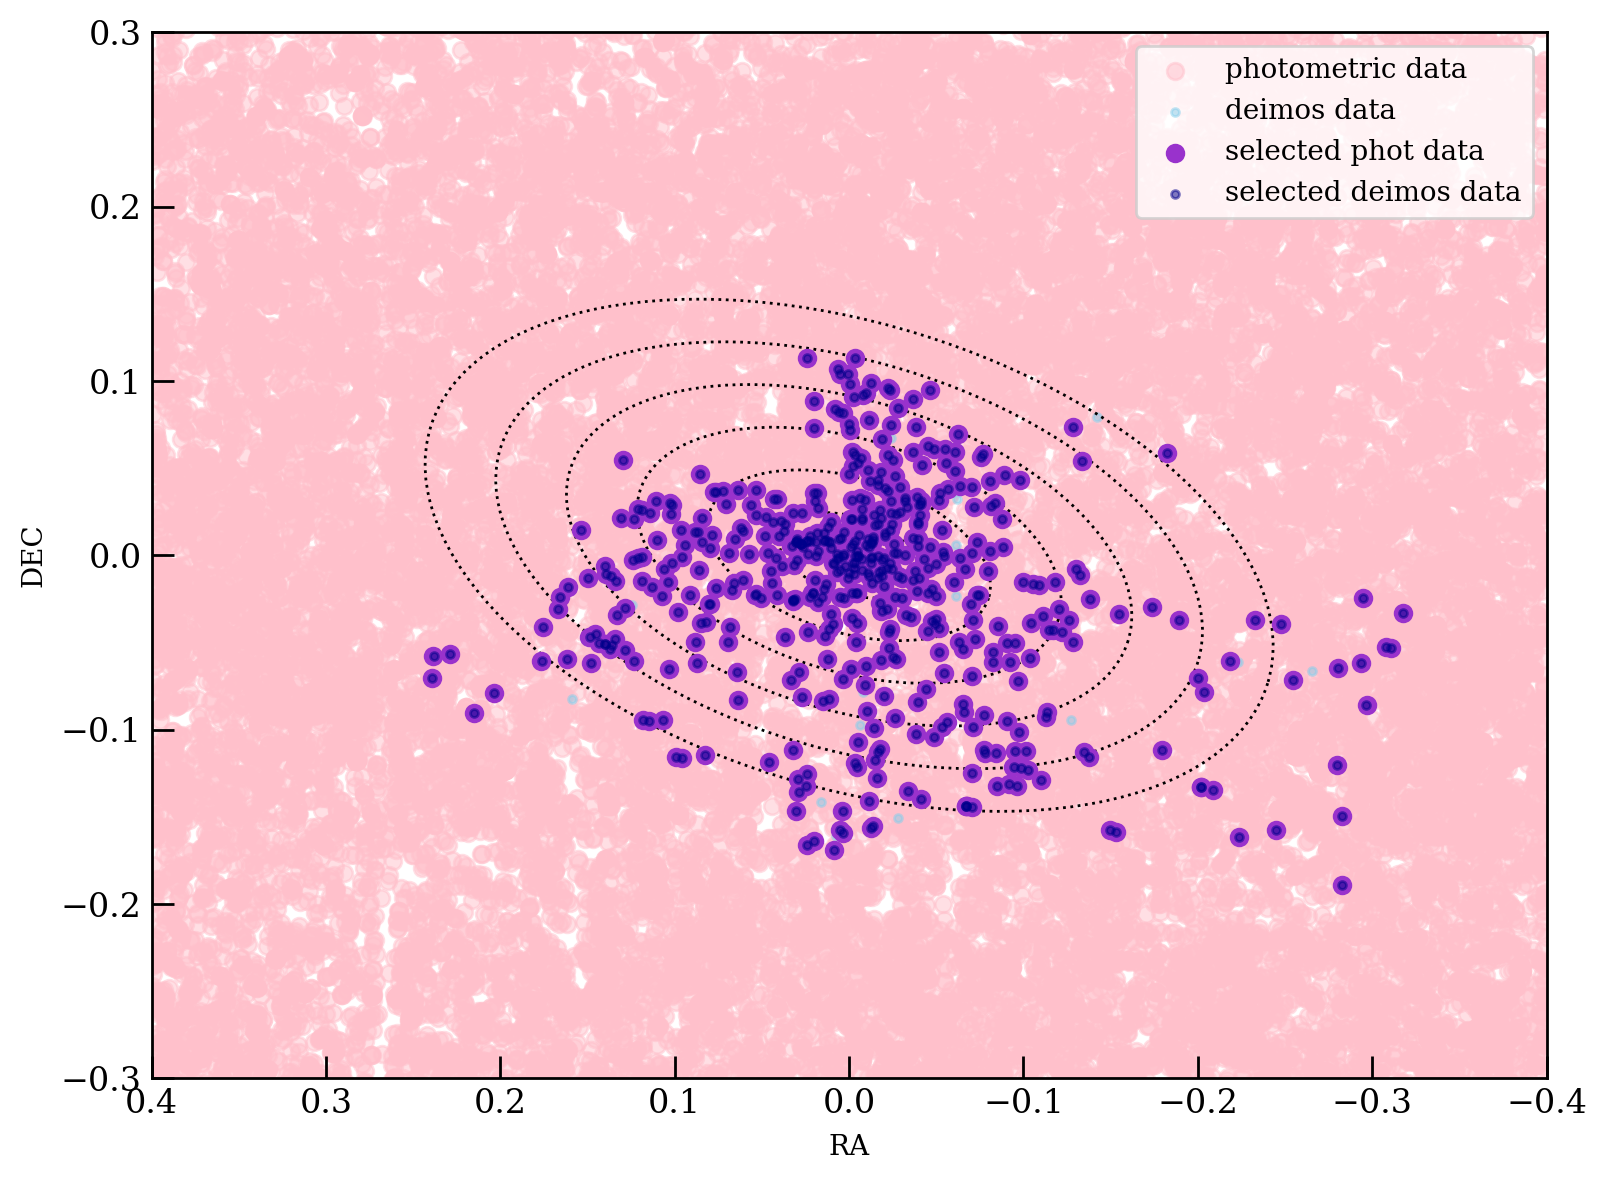

In [25]:
# spatial distribution
fig = plt.figure(figsize = (9, 9))
ax = fig.gca()

ax.set_aspect("equal")

ax.scatter(munoz_phot["delta_ra_cos_dec"], munoz_phot["delta_dec"], 
           c = "pink", alpha = 0.5, zorder = 0, label = "photometric data")
ax.scatter(full_deimos["delta_ra_cosdec"], full_deimos["delta_dec"], 
           c = "skyblue", alpha = 0.5, s = 8, zorder = 1, label = "deimos data")

ax.scatter(deimos_phot_combined["delta_ra_cos_dec"], deimos_phot_combined["delta_dec"].iloc[:, 0], 
           c = "darkorchid", zorder = 3, label = "selected phot data")
ax.scatter(deimos_phot_combined["delta_ra_cosdec"], deimos_phot_combined["delta_dec"].iloc[:, 0], 
           alpha = 0.5, c = "darkblue", s = 8, zorder = 4, label = "selected deimos data")

for ii in range(6): # half-light radii
    jj = 2 * (ii + 1)
    ellipse = Ellipse((0, 0), bax * jj, aax * jj, angle = 360-73, fill = False, linestyle = ":", edgecolor = "black")
    ax.add_patch(ellipse)

ax.set_xlabel("RA", labelpad = 5, size = 10).set_color('black')
ax.set_ylabel("DEC", labelpad = 5, size = 10).set_color('black')

ax.set_xlim(0.4, -0.4)
ax.set_ylim(-0.3, 0.3)

ax.legend(loc = 'upper right', fontsize = 10, frameon = True)

# fig.savefig("deimos_munoz_spatial.pdf", dpi = 600, transparent = True)

(14.0, 26.0)

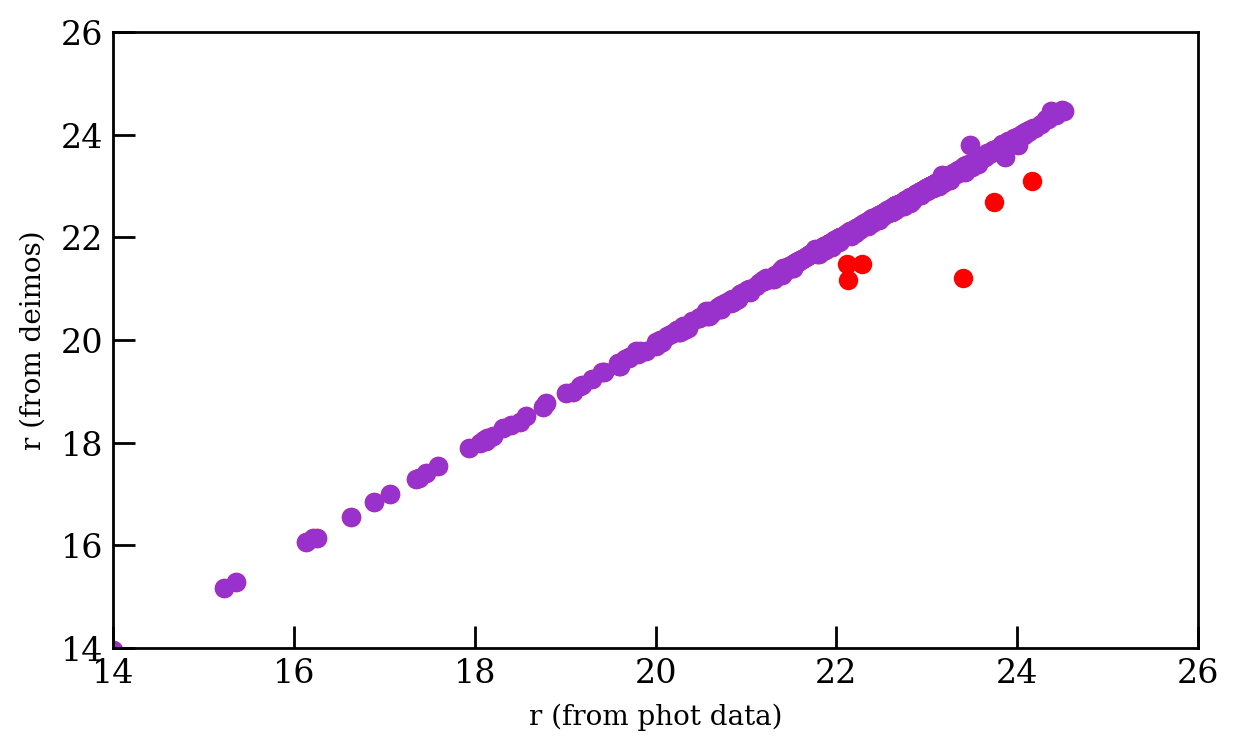

In [26]:
# check color, magnitude values
fig = plt.figure(figsize = (7, 4))
ax = fig.gca()

ax.scatter(deimos_phot_combined["rmag_o"].values[:, 0], deimos_phot_combined["rmag_o"].values[:, 1], c = "red")
deimos_phot_combined = deimos_phot_combined[abs(deimos_phot_combined["rmag_o"].iloc[:, 0] - deimos_phot_combined["rmag_o"].iloc[:, 1]) < 0.5]
ax.scatter(deimos_phot_combined["rmag_o"].values[:, 0], deimos_phot_combined["rmag_o"].values[:, 1], c = "darkorchid")

ax.set_xlabel("r (from phot data)", labelpad = 5, size = 10).set_color('black')
ax.set_ylabel("r (from deimos)", labelpad = 5, size = 10).set_color('black')

ax.set_xlim(14, 26)
ax.set_ylim(14, 26)

# fig.savefig("deimos_munoz_mag.pdf", dpi = 600, transparent = True)

In [27]:
# cut munoz and deimos data to probable members
cut_munoz_phot = munoz_phot[(munoz_phot["hl_radius_ell"] <= 3) & (munoz_phot["cmd_marker"] >= 0.5)]
cut_deimos = full_deimos[(full_deimos["hl_radius_ell"] <= 3) & (full_deimos["cmd_marker"] >= 0.5)]
deimos_phot_combined = deimos_phot_combined[(deimos_phot_combined["hl_radius_ell"].iloc[:, 0] <= 3)
                                            & ((deimos_phot_combined["cmd_marker"].iloc[:, 0] >= 0.5) & 
                                               (deimos_phot_combined["cmd_marker"].iloc[:, 1] >= 0.5))]

print("rhalf < 3 and P_CMD > 0.5")
print("-------------------------")
print("Munoz phot :  {} sources".format(len(cut_munoz_phot)))
print("Deimos data : {} sources".format(len(cut_deimos)))
print("Overlap :     {} sources".format(len(deimos_phot_combined)))

rhalf < 3 and P_CMD > 0.5
-------------------------
Munoz phot :  800 sources
Deimos data : 216 sources
Overlap :     205 sources


In [28]:
def cummulative_percent(max_mag):
    percent_df = pd.DataFrame() # new df with empty columns
    percent_df["r_half"] = np.arange(0, 3.1, 0.1)
    percent_df["percent"], percent_df["n_total"], percent_df["n_overlap"] = np.nan, np.nan, np.nan
    
    for i in range(len(percent_df)): # loop through r_half values
        r_max = percent_df.loc[i, "r_half"]
        # calculate total stars in phot data
        total = cut_munoz_phot[(cut_munoz_phot["hl_radius_ell"] <= r_max) & (cut_munoz_phot["rmag_o"] <= max_mag)]
        # calculate stars in deimos data
        sample = cut_deimos[(cut_deimos["hl_radius_ell"] <= r_max) & (cut_deimos["rmag_o"] <= max_mag)]
        # calculate overlap stars
        sample_overlap = deimos_phot_combined[(deimos_phot_combined["hl_radius_ell"].iloc[:, 0] <= r_max) & 
                                              (deimos_phot_combined["rmag_o"].iloc[:, 0] <= max_mag)]

        if len(total) != 0: # save to dataframe
            percent_df.loc[i, "percent"] = (len(sample_overlap) / len(total))
            percent_df.loc[i, "n_total"] = len(total)
            percent_df.loc[i, "n_overlap"] = len(sample_overlap)

    return percent_df

In [29]:
def discrete_percent(min_mag, max_mag):
    percent_df = pd.DataFrame() # new df with empty columns
    percent_df["r_half"] = np.arange(0, 3.1, 0.1)
    percent_df["percent"], percent_df["n_total"], percent_df["n_overlap"] = np.nan, np.nan, np.nan

    for i in range(len(percent_df)): # loop through r_half values
        r_max = percent_df.loc[i, "r_half"]
        # calculate total stars in phot data
        total = cut_munoz_phot[(cut_munoz_phot["hl_radius_ell"] <= r_max) & 
                               (cut_munoz_phot["rmag_o"] <= max_mag) & (cut_munoz_phot["rmag_o"] >= min_mag)]
        # calculate stars in deimos data
        sample = cut_deimos[(cut_deimos["hl_radius_ell"] <= r_max) & 
                            (cut_deimos["rmag_o"] <= max_mag) & (cut_deimos["rmag_o"] >= min_mag)]
        # calculate overlap stars
        sample_overlap = deimos_phot_combined[(deimos_phot_combined["hl_radius_ell"].iloc[:, 0] <= r_max) & 
                                              (deimos_phot_combined["rmag_o"].iloc[:, 0] <= max_mag) & 
                                              (deimos_phot_combined["rmag_o"].iloc[:, 0] >= min_mag)]
        
        if len(total) != 0: # save to dataframe
            percent_df.loc[i, "percent"] = (len(sample_overlap) / len(total))
            percent_df.loc[i, "n_total"] = len(total)
            percent_df.loc[i, "n_overlap"] = len(sample_overlap)

    return percent_df

In [35]:
dp_17_df = cummulative_percent(17)
dp_19_df = cummulative_percent(19)
dp_20_df = cummulative_percent(20)
dp_21_df = cummulative_percent(21)
dp_22_df = cummulative_percent(22)
dp_23_df = cummulative_percent(23)
dp_24_df = cummulative_percent(24)

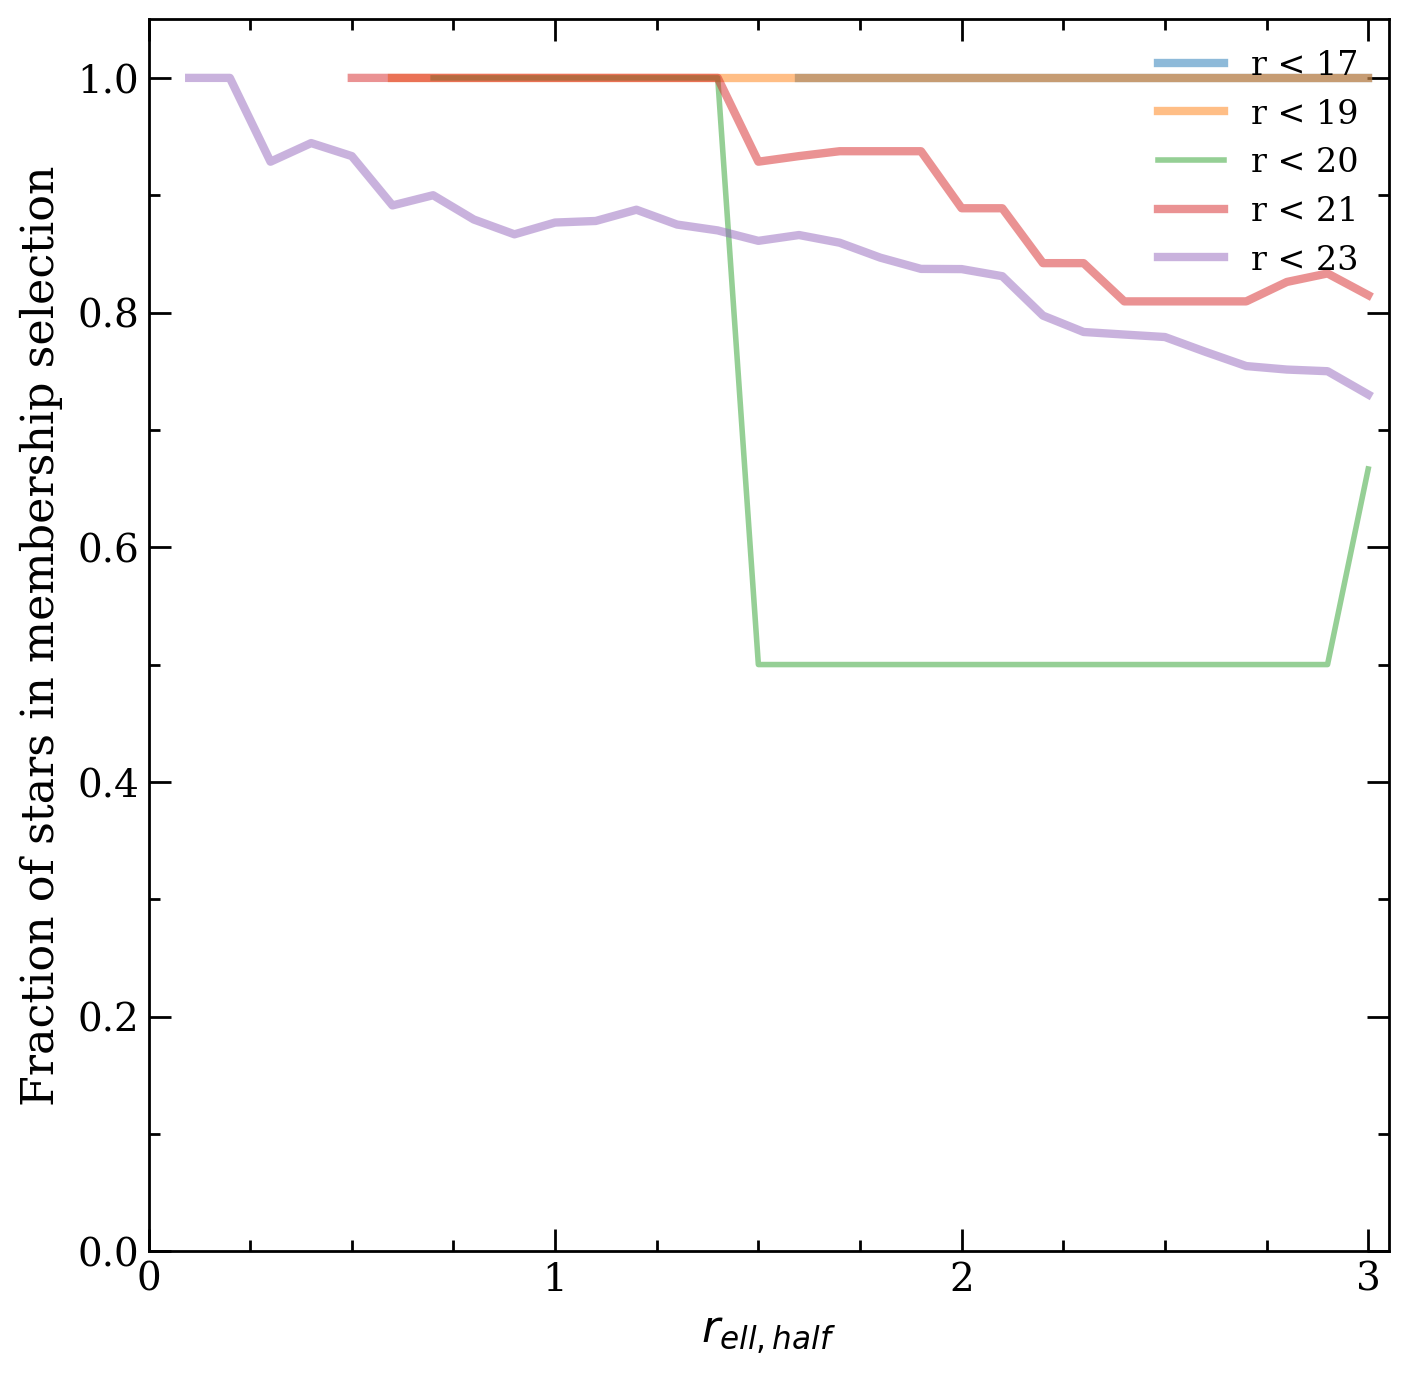

In [45]:
fig = plt.figure(figsize=(8, 8))
ax = fig.gca()

mag_17 = sns.lineplot(x = "r_half", y = "percent", data = dp_17_df, markers = True, alpha = 0.5, linewidth = 3, label = "r < 17")
mag_19 = sns.lineplot(x = "r_half", y = "percent", data = dp_19_df, markers = True, alpha = 0.5, linewidth = 3, label = "r < 19")
mag_20 = sns.lineplot(x = "r_half", y = "percent", data = dp_20_df, markers = True, alpha = 0.5, linewidth = 2, label = "r < 20")
mag_21 = sns.lineplot(x = "r_half", y = "percent", data = dp_21_df, markers = True, alpha = 0.5, linewidth = 3, label = "r < 21")
#mag_22 = sns.lineplot(x = "r_half", y = "percent", data = dp_22_df, markers = True, alpha = 0.5, linewidth = 2, label = "test")
mag_23 = sns.lineplot(x = "r_half", y = "percent", data = dp_23_df, markers = True, alpha = 0.5, linewidth = 3, label = "r < 23")
#mag_24 = sns.lineplot(x = "r_half", y = "percent", data = dp_24_df, markers = True, alpha = 0.5, linewidth = 2, label = "test")

#Customizations
ax.set_xlabel("$r_{ell, half}$", labelpad = 5, size = 16)
ax.set_ylabel("Fraction of stars in membership selection", labelpad = 5, size = 16)
ax.set_xlim([0, 3.05])
ax.set_ylim([0, 1.05])

ax.set_xticks(np.arange(0, 4, 1), minor = False)
ax.set_xticks(np.arange(0, 3.25, 0.25), minor = True)
ax.tick_params(which = "major", axis = "x", direction = "in", size = 8, labelsize = 14, color = "black", top = True)
ax.tick_params(which = "minor", axis = "x", direction = "in", size = 4, color = "black", top = True)

ax.set_yticks(np.arange(0, 1.2, 0.2), minor = False)
ax.set_yticks(np.arange(0, 1.1, 0.1), minor = True)
ax.tick_params(which = "major", axis = "y", direction = "in", size = 8, labelsize = 14, color = "black", right = True)
ax.tick_params(which = "minor", axis = "y", direction = "in", size = 4, color = "black", right = True)

ax.legend(loc = "upper right", fontsize = 12, frameon = False)

# fig.savefig("wil1_completeness_cumulative.pdf", dpi = 600, transparent = True)

In [46]:
dp_17_df1 = discrete_percent(0, 17)
dp_19_df1 = discrete_percent(17, 19)
dp_20_df = discrete_percent(19, 20)
dp_21_df1 = discrete_percent(20, 21)
#dp_22_df = discrete_percent(22)
dp_23_df1 = discrete_percent(21, 23)
#dp_24_df = discrete_percent(24)
dp_tot_df1 = discrete_percent(23, 27)

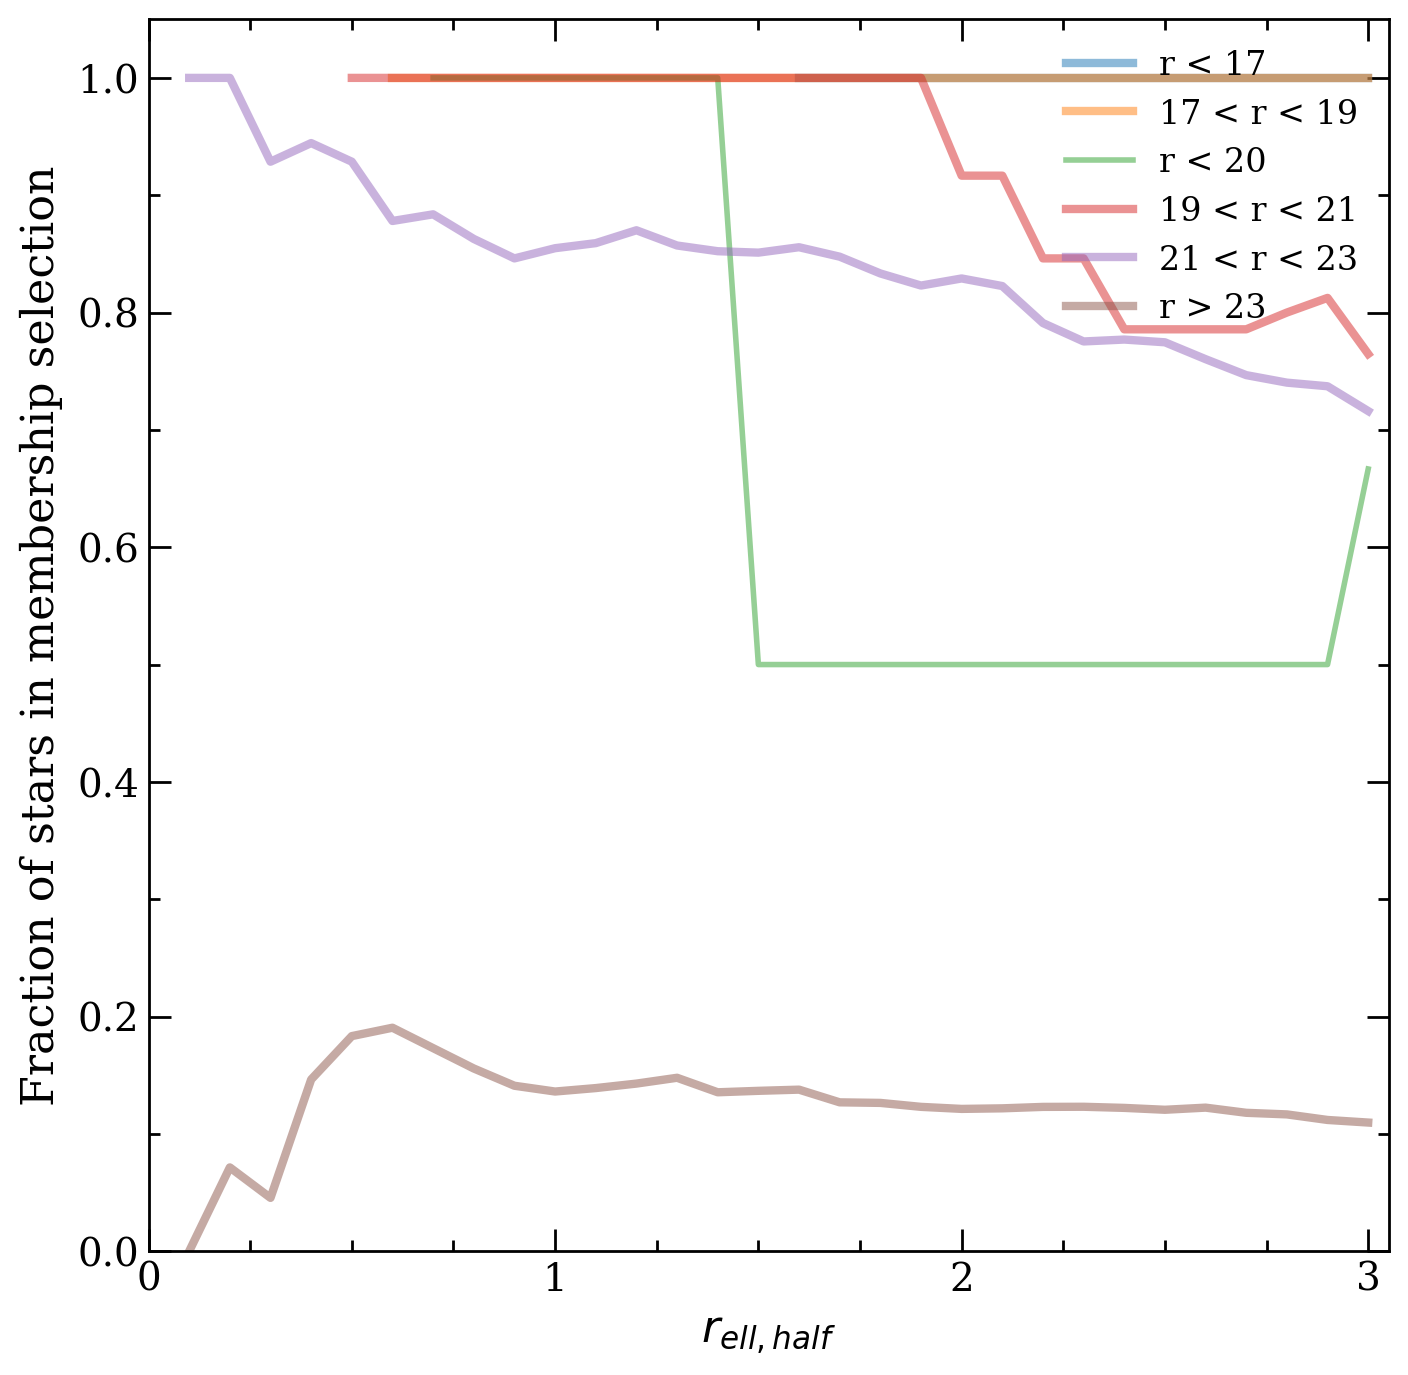

In [47]:
fig = plt.figure(figsize=(8, 8))
ax = fig.gca()

import seaborn as sns
#ax.axvline(x = 0.7, linestyle = "--", c = "black", label = "location of step function")

mag_17 = sns.lineplot(x = "r_half", y = "percent", data = dp_17_df1, markers = True, alpha = 0.5, linewidth = 3, label = "r < 17")
mag_19 = sns.lineplot(x = "r_half", y = "percent", data = dp_19_df1, markers = True, alpha = 0.5, linewidth = 3, label = "17 < r < 19")
mag_20 = sns.lineplot(x = "r_half", y = "percent", data = dp_20_df, markers = True, alpha = 0.5, linewidth = 2, label = "r < 20")
mag_21 = sns.lineplot(x = "r_half", y = "percent", data = dp_21_df1, markers = True, alpha = 0.5, linewidth = 3, label = "19 < r < 21")
#mag_22 = sns.lineplot(x = "r_half", y = "percent", data = dp_22_df, markers = True, alpha = 0.5, linewidth = 2, label = "test")
mag_23 = sns.lineplot(x = "r_half", y = "percent", data = dp_23_df1, markers = True, alpha = 0.5, linewidth = 3, label = "21 < r < 23")
#mag_24 = sns.lineplot(x = "r_half", y = "percent", data = dp_24_df, markers = True, alpha = 0.5, linewidth = 2, label = "test")
mag_tot = sns.lineplot(x = "r_half", y = "percent", data = dp_tot_df1, markers = True, alpha = 0.5, linewidth = 3, label = "r > 23")

#Customizations
ax.set_xlabel("$r_{ell, half}$", labelpad = 5, size = 16)
ax.set_ylabel("Fraction of stars in membership selection", labelpad = 5, size = 16)
ax.set_xlim([0, 3.05])
ax.set_ylim([0, 1.05])

ax.set_xticks(np.arange(0, 4, 1), minor = False)
ax.set_xticks(np.arange(0, 3.25, 0.25), minor = True)
ax.tick_params(which = "major", axis = "x", direction = "in", size = 8, labelsize = 14, color = "black", top = True)
ax.tick_params(which = "minor", axis = "x", direction = "in", size = 4, color = "black", top = True)

ax.set_yticks(np.arange(0, 1.2, 0.2), minor = False)
ax.set_yticks(np.arange(0, 1.1, 0.1), minor = True)
ax.tick_params(which = "major", axis = "y", direction = "in", size = 8, labelsize = 14, color = "black", right = True)
ax.tick_params(which = "minor", axis = "y", direction = "in", size = 4, color = "black", right = True)

ax.legend(loc = "upper right", fontsize = 12, frameon = False)

#fig.savefig("wil1_completeness_discrete.pdf", dpi = 600, transparent = True)

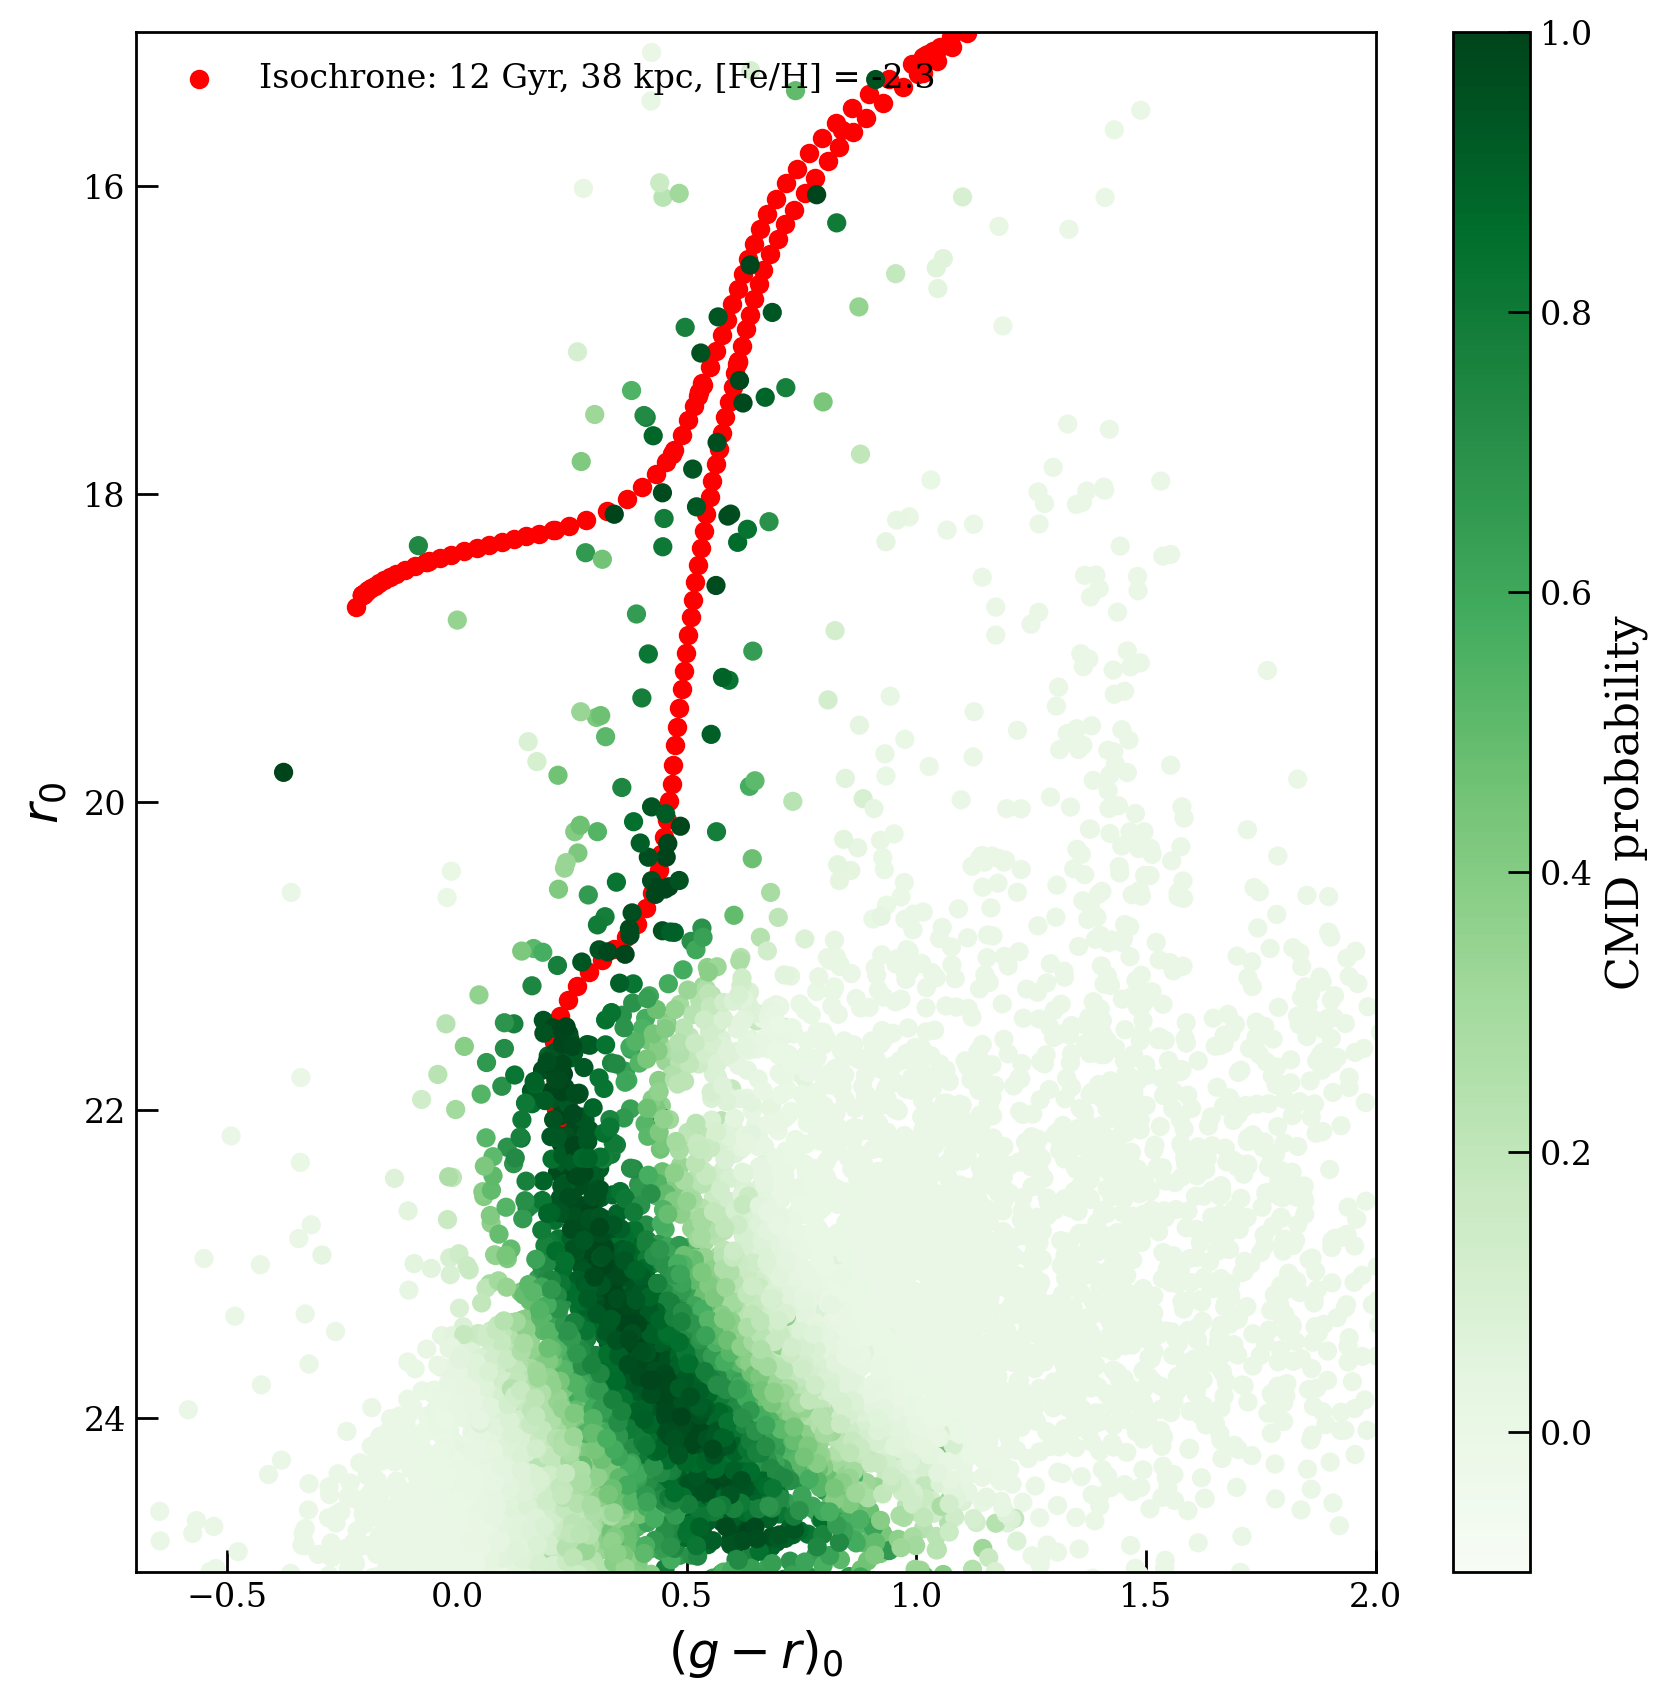

In [41]:
fig = plt.figure(figsize=(10, 10))
ax = fig.gca()

ax.scatter(iso_data["gr"], iso_data["r"], c = "red", label = "Isochrone: 12 Gyr, 38 kpc, [Fe/H] = -2.3") #iso
rhalf_cut_munoz = munoz_phot[munoz_phot["hl_radius_ell"] <= 6]
data = ax.scatter(rhalf_cut_munoz["g"] - rhalf_cut_munoz["r"], rhalf_cut_munoz["r"], c = rhalf_cut_munoz["cmd_marker"], cmap = "Greens", s = 35, vmin = -0.1, vmax = 1, zorder = 2) #full data

ax.set_xlim(-0.7, 2)
ax.set_ylim(25, 15)

ax.set_xlabel("$(g-r)_0$", labelpad = 5, size = 18).set_color('black')
ax.set_ylabel("$r_0$", labelpad = 5, size = 18).set_color('black')

cbar = plt.colorbar(data)
cbar.set_label("CMD probability")

ax.legend(loc = 'upper left', fontsize = 12, frameon = False)

#fig.savefig("phot_cmd.pdf", dpi = 600, transparent = True)